Haven't we always looked at something and wonder if it's a car or plane or maybe bus. In this post, we are going to tackle this problem using AI. We will train a model to recognise if image is of car or plane or bus.

This method is called supervised learning and here we will train it for three categories but it can be expanded for as many needed. Following are the steps we will go through:


1. Use search engine i.e. 'duckduckgo' to collect images
2. Fine tune a pretrained model to recognised these groups
3. Test on unseen image to see if it works


In [22]:
from fastbook import *
from fastai.vision.widgets import *

In [2]:
# Here we are going to use FASTAI(a framework to simplify training procedure) so we import all the stuff we are going to need
from fastcore.all import *
import json
from urllib.error import URLError,HTTPError
import time
from pathlib import Path
from fastai.vision.all import *

To collect images, we are going to utilize DuckDuckGo. There are some pip packages available like 'duckduckgo_search' but sometime they are fidly so we write a custom function to do same. Pass a search term and function will return link to images.

In [3]:
def search_images_ddg(term, max_images=200):
    "Search for `term` with DuckDuckGo and return a unique urls of about `max_images` images"
    print(f'searching for {term}')
    assert max_images<1000
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    assert searchObj
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    headers = dict(referer='https://duckduckgo.com/')
    while len(urls)<max_images and 'next' in data:
        try:
            res = urlread(requestUrl, data=params, headers=headers)
            data = json.loads(res) if res else {}
            urls.update(L(data['results']).itemgot('image'))
            requestUrl = url + data['next']
        except (URLError,HTTPError): pass
        time.sleep(1)
    return L(urls)[:max_images]

In [4]:
# Set Data foler to keep store images
DATA_DIR = "../Data/"
Path(DATA_DIR).mkdir(parents=True, exist_ok=True)

Let's test if we can search and dowload images

searching for car


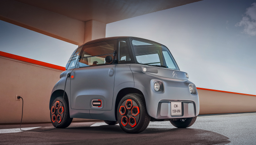

In [5]:
dest = DATA_DIR + '/car.jpg'
urls = search_images_ddg("car", max_images=1)
download_url(urls[0], dest)

im = Image.open(dest)
im.to_thumb(256, 256)

searching for plane photos


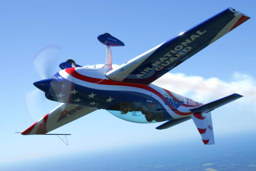

In [6]:
dest = DATA_DIR + '/plane.jpg'
urls = search_images_ddg("plane photos", max_images=1)
download_url(urls[0], dest)


im = Image.open(dest)
im.to_thumb(256, 256)

searching for bus photos


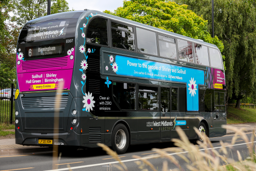

In [7]:
dest = DATA_DIR + '/bus.jpg'
urls = search_images_ddg("bus photos", max_images=1)
download_url(urls[0], dest)


im = Image.open(dest)
im.to_thumb(256, 256)

So we are set to download all images. Here we sample 100 images of each and save in foldername as categories.

In [8]:
path = Path(DATA_DIR+'/images')

searches = ['car', 'plane', 'bus']

for search in searches:
    dest = (path/search)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images_ddg(f'{search} photo', max_images=100))
    time.sleep(10)
    resize_images(dest, max_size=400, dest=dest)
    print("Resized complete")
    
    
    

searching for car photo
Resized complete
searching for plane photo
Resized complete
searching for bus photo
Resized complete


There might be some images which are not invalid. Let's remove them from our dataset

In [9]:
# remove failed images

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

7

To train the model, first we need to create DataLoader. You can think of dataloader as way to embed information about labeling, resizing, splitting data for validation for training. Here we are using 'squish' method to transform all images and resizing to 192 px

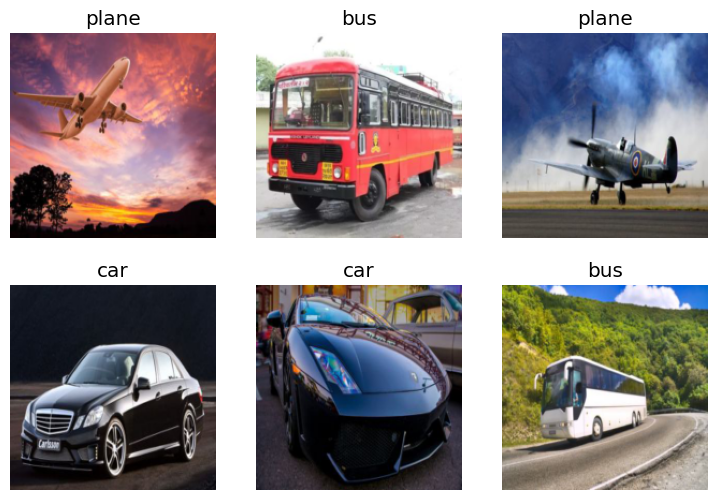

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)


We feed dataloader to vision_learner which trains the model on top of already trained model, here we are using resnet18

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/Users/sachin/miniforge3/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sachin/miniforge3/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.068014,0.019066,0.000000,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.180940,0.001668,0.000000,00:11
1,0.112269,0.000446,0.000000,00:10
2,0.077793,0.001140,0.000000,00:10


So that took less than minute on cpu with accuracy of 100%.. Pretty awesome ya! Now we plot Confusion matrix to interpret results from model

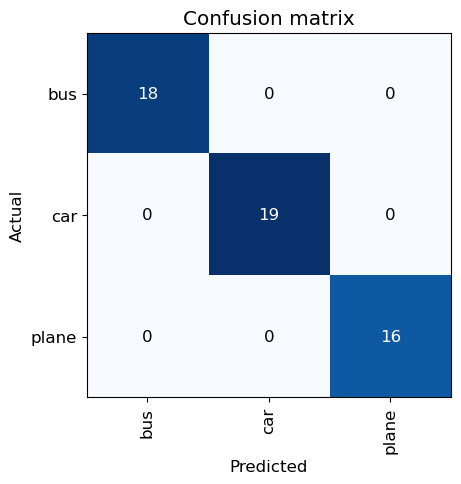

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Now to use this model, we can save it as pkl file so we don't have to train everytime. 

In [15]:
export_model_path = DATA_DIR +'/model.pkl'
learn.export(export_model_path)

Let's look at how we can ship this pickle and use it in an app to classify images. We first load model from pkl file 

In [16]:
learn_inf = load_learner(export_model_path)

and that's all. we can just pass the image to inference to make prediction

In [17]:
learn_inf.predict(DATA_DIR+'/plane.jpg')

('plane', TensorBase(2), TensorBase([3.6930e-05, 1.4452e-03, 9.9852e-01]))

However to make it pretty we need to use labels properly. Model also have info about categories.

In [18]:
learn_inf.dls.vocab

['bus', 'car', 'plane']

Here we write a simple function to make the output easier to read.

In [19]:
def get_output(file_name):
    file_path = DATA_DIR + f'/{file_name}'
    label,index,probs = learn.predict(PILImage.create(file_path))
    print(index)
    print(f"This is a {label}.")
    print(f"Probability it's a bus: {probs[0]:.4f}")
    print(f"Probability it's a car: {probs[1]:.4f}")
    print(f"Probability it's a plane: {probs[2]:.4f}")
    im = Image.open(file_path)
    return im.to_thumb(256, 256)

Let's test it on images we downloaded initially and were not used in training the model.

TensorBase(2)
This is a plane.
Probability it's a bus: 0.0000
Probability it's a car: 0.0014
Probability it's a plane: 0.9985


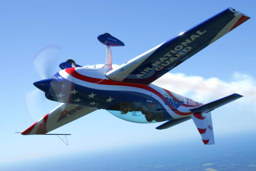

In [20]:
get_output('plane.jpg')

Prefect Result. Now we never have to wonder whether it's a car or plane or a bus!

This post is first of our introductory tech blog, for domains
<a href="https://www.devicion.com/">Devicion</a> has expertise in. At Devicion, we don't just deliver services; we forge partnerships. Our team collaborates closely with you, understanding your goals and challenges to deliver solutions that surpass expectations. 


Next we will explore how to create a web app using Django and React and the model we just trained.

This notebooks is also available on git https://github.com/devicion/deep-backend 


 